In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import seaborn as sns
import pickle
import math

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 700)

The data sampling for additional SOD labeling will be done according to the analysis results of Gelderman_SOD_cohort_analysis.ipynb.

# Import master dataset and process it

In [7]:
# import master dataset
master_data = pd.read_pickle('../data/master_dataset.pkl')
print(len(master_data))
display(master_data.head())

1132970


,new_id,old_id,img_path,img,correct_img_date,date_placed_ARF,PMI_days,year,age_at_death,race,sex,autopsy,est_weight_lb,est_weight_kg,est_stature_in,est_stature_cm,cadaver_stature_cm,cadaver_weight_lbs,date_placed_ARF_freezer,true_BP,pred_BP,pred_BP_conf,true_SOD_G,BP_of_true_SOD_G,pred_SOD_G,pred_SOD_G_conf,true_SOD_M,BP_of_true_SOD_M
0,000,UT01-18D,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000121.01.JPG,00000121.01.JPG,2018-01-21,2018-01-21,0.0,2018,73.0,white,Male,False,160.0,72.562358,70.0,177.8,169.0,150.0,2018-01-04,NaN,stake,100.00,NaN,NaN,NaN,NaN,NaN,NaN
1,000,UT01-18D,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000121.02.JPG,00000121.02.JPG,2018-01-21,2018-01-21,0.0,2018,73.0,white,Male,False,160.0,72.562358,70.0,177.8,169.0,150.0,2018-01-04,NaN,fullbody,85.51,NaN,NaN,NaN,NaN,NaN,NaN
2,000,UT01-18D,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000121.03.JPG,00000121.03.JPG,2018-01-21,2018-01-21,0.0,2018,73.0,white,Male,False,160.0,72.562358,70.0,177.8,169.0,150.0,2018-01-04,NaN,fullbody,90.52,NaN,NaN,NaN,NaN,NaN,NaN
3,000,UT01-18D,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000121.04.JPG,00000121.04.JPG,2018-01-21,2018-01-21,0.0,2018,73.0,white,Male,False,160.0,72.562358,70.0,177.8,169.0,150.0,2018-01-04,NaN,fullbody,99.50,NaN,NaN,NaN,NaN,NaN,NaN
4,000,UT01-18D,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000121.05.JPG,00000121.05.JPG,2018-01-21,2018-01-21,0.0,2018,73.0,white,Male,False,160.0,72.562358,70.0,177.8,169.0,150.0,2018-01-04,NaN,fullbody,43.47,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# extract donor_date from img column
master_data['donor_date'] = master_data.img.str.split('.', expand=True)[0]
display(master_data.head(3))

,new_id,old_id,img_path,img,correct_img_date,date_placed_ARF,PMI_days,year,age_at_death,race,sex,autopsy,est_weight_lb,est_weight_kg,est_stature_in,est_stature_cm,cadaver_stature_cm,cadaver_weight_lbs,date_placed_ARF_freezer,true_BP,pred_BP,pred_BP_conf,true_SOD_G,BP_of_true_SOD_G,pred_SOD_G,pred_SOD_G_conf,true_SOD_M,BP_of_true_SOD_M,donor_date
0,000,UT01-18D,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000121.01.JPG,00000121.01.JPG,2018-01-21,2018-01-21,0.0,2018,73.0,white,Male,False,160.0,72.562358,70.0,177.8,169.0,150.0,2018-01-04,NaN,stake,100.00,NaN,NaN,NaN,NaN,NaN,NaN,00000121
1,000,UT01-18D,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000121.02.JPG,00000121.02.JPG,2018-01-21,2018-01-21,0.0,2018,73.0,white,Male,False,160.0,72.562358,70.0,177.8,169.0,150.0,2018-01-04,NaN,fullbody,85.51,NaN,NaN,NaN,NaN,NaN,NaN,00000121
2,000,UT01-18D,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000121.03.JPG,00000121.03.JPG,2018-01-21,2018-01-21,0.0,2018,73.0,white,Male,False,160.0,72.562358,70.0,177.8,169.0,150.0,2018-01-04,NaN,fullbody,90.52,NaN,NaN,NaN,NaN,NaN,NaN,00000121


In [9]:
# create final_BP column
master_data['final_BP'] = np.where(master_data['true_BP'].notnull(), 
                                            master_data['true_BP'],
                                            master_data['pred_BP'])
display(master_data.head(3))
len(master_data)

,new_id,old_id,img_path,img,correct_img_date,date_placed_ARF,PMI_days,year,age_at_death,race,sex,autopsy,est_weight_lb,est_weight_kg,est_stature_in,est_stature_cm,cadaver_stature_cm,cadaver_weight_lbs,date_placed_ARF_freezer,true_BP,pred_BP,pred_BP_conf,true_SOD_G,BP_of_true_SOD_G,pred_SOD_G,pred_SOD_G_conf,true_SOD_M,BP_of_true_SOD_M,donor_date,final_BP
0,000,UT01-18D,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000121.01.JPG,00000121.01.JPG,2018-01-21,2018-01-21,0.0,2018,73.0,white,Male,False,160.0,72.562358,70.0,177.8,169.0,150.0,2018-01-04,NaN,stake,100.00,NaN,NaN,NaN,NaN,NaN,NaN,00000121,stake
1,000,UT01-18D,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000121.02.JPG,00000121.02.JPG,2018-01-21,2018-01-21,0.0,2018,73.0,white,Male,False,160.0,72.562358,70.0,177.8,169.0,150.0,2018-01-04,NaN,fullbody,85.51,NaN,NaN,NaN,NaN,NaN,NaN,00000121,fullbody
2,000,UT01-18D,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000121.03.JPG,00000121.03.JPG,2018-01-21,2018-01-21,0.0,2018,73.0,white,Male,False,160.0,72.562358,70.0,177.8,169.0,150.0,2018-01-04,NaN,fullbody,90.52,NaN,NaN,NaN,NaN,NaN,NaN,00000121,fullbody


1132970

In [10]:
# remove images where true_BP.isnull() AND pred_BP_conf < 80
master_data_filtered = master_data[(master_data.true_BP.notnull()) | 
                                   ((master_data.true_BP.isnull()) & (master_data.pred_BP_conf >= 80.0))].copy()
display(master_data_filtered.head(3))
len(master_data_filtered)

,new_id,old_id,img_path,img,correct_img_date,date_placed_ARF,PMI_days,year,age_at_death,race,sex,autopsy,est_weight_lb,est_weight_kg,est_stature_in,est_stature_cm,cadaver_stature_cm,cadaver_weight_lbs,date_placed_ARF_freezer,true_BP,pred_BP,pred_BP_conf,true_SOD_G,BP_of_true_SOD_G,pred_SOD_G,pred_SOD_G_conf,true_SOD_M,BP_of_true_SOD_M,donor_date,final_BP
0,000,UT01-18D,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000121.01.JPG,00000121.01.JPG,2018-01-21,2018-01-21,0.0,2018,73.0,white,Male,False,160.0,72.562358,70.0,177.8,169.0,150.0,2018-01-04,NaN,stake,100.00,NaN,NaN,NaN,NaN,NaN,NaN,00000121,stake
1,000,UT01-18D,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000121.02.JPG,00000121.02.JPG,2018-01-21,2018-01-21,0.0,2018,73.0,white,Male,False,160.0,72.562358,70.0,177.8,169.0,150.0,2018-01-04,NaN,fullbody,85.51,NaN,NaN,NaN,NaN,NaN,NaN,00000121,fullbody
2,000,UT01-18D,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000121.03.JPG,00000121.03.JPG,2018-01-21,2018-01-21,0.0,2018,73.0,white,Male,False,160.0,72.562358,70.0,177.8,169.0,150.0,2018-01-04,NaN,fullbody,90.52,NaN,NaN,NaN,NaN,NaN,NaN,00000121,fullbody


912242

In [14]:
# keep only where final_BP = head, torso, or  limbs imgs
BP_ls = ['head', 'torso', 'backside', 'arm', 'legs']
master_data_filtered = master_data_filtered[(master_data_filtered.final_BP.isin(BP_ls))].copy()
print(len(master_data_filtered))
print(master_data_filtered.final_BP.unique())
display(master_data_filtered.head())

538485
['torso' 'head' 'arm' 'legs' 'backside']


,new_id,old_id,img_path,img,correct_img_date,date_placed_ARF,PMI_days,year,age_at_death,race,sex,autopsy,est_weight_lb,est_weight_kg,est_stature_in,est_stature_cm,cadaver_stature_cm,cadaver_weight_lbs,date_placed_ARF_freezer,true_BP,pred_BP,pred_BP_conf,true_SOD_G,BP_of_true_SOD_G,pred_SOD_G,pred_SOD_G_conf,true_SOD_M,BP_of_true_SOD_M,donor_date,final_BP
12,000,UT01-18D,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000122.04.JPG,00000122.04.JPG,2018-01-22,2018-01-21,1.0,2018,73.0,white,Male,False,160.0,72.562358,70.0,177.8,169.0,150.0,2018-01-04,NaN,torso,94.74,NaN,NaN,NaN,NaN,NaN,NaN,00000122,torso
13,000,UT01-18D,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000122.05.JPG,00000122.05.JPG,2018-01-22,2018-01-21,1.0,2018,73.0,white,Male,False,160.0,72.562358,70.0,177.8,169.0,150.0,2018-01-04,NaN,torso,99.77,NaN,NaN,NaN,NaN,NaN,NaN,00000122,torso
15,000,UT01-18D,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000122.07.JPG,00000122.07.JPG,2018-01-22,2018-01-21,1.0,2018,73.0,white,Male,False,160.0,72.562358,70.0,177.8,169.0,150.0,2018-01-04,NaN,head,100.00,NaN,NaN,NaN,NaN,NaN,NaN,00000122,head
16,000,UT01-18D,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000122.08.JPG,00000122.08.JPG,2018-01-22,2018-01-21,1.0,2018,73.0,white,Male,False,160.0,72.562358,70.0,177.8,169.0,150.0,2018-01-04,NaN,head,100.00,NaN,NaN,NaN,NaN,2.0,head,00000122,head
17,000,UT01-18D,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000122.09.JPG,00000122.09.JPG,2018-01-22,2018-01-21,1.0,2018,73.0,white,Male,False,160.0,72.562358,70.0,177.8,169.0,150.0,2018-01-04,NaN,arm,99.74,NaN,NaN,NaN,NaN,NaN,NaN,00000122,arm


In [15]:
# BMI distribution (CDC BMI categories: underweight, healthy, overweight, obese)
# https://www.cdc.gov/healthyweight/assessing/index.html#:~:text=If%20your%20BMI%20is%20less,falls%20within%20the%20obese%20range.
def bmi_imperial(weight_lbs, height_in):
    bmi = round(703*(weight_lbs/(height_in**2)), 1)
    return bmi

def bmi_status(bmi):
    if bmi < 18.5:
        status = 'underweight'
    elif 18.5 <= bmi <= 24.9:
        status = 'healthy'
    elif 24.9 < bmi <= 29.9:
        status = 'overweight'
    elif bmi > 29.9:
        status = 'obese'
    elif pd.isna(bmi):
        status = float('nan')
    return status

# add BMI and BMI_status column
master_data_filtered['BMI'] = master_data_filtered.apply(lambda x: bmi_imperial(x['cadaver_weight_lbs'], x['est_stature_in'])
                                               , axis=1)
master_data_filtered['BMI_status'] = master_data_filtered.apply(lambda x: bmi_status(x['BMI']), axis=1)
display(master_data_filtered.head())

,new_id,old_id,img_path,img,correct_img_date,date_placed_ARF,PMI_days,year,age_at_death,race,sex,autopsy,est_weight_lb,est_weight_kg,est_stature_in,est_stature_cm,cadaver_stature_cm,cadaver_weight_lbs,date_placed_ARF_freezer,true_BP,pred_BP,pred_BP_conf,true_SOD_G,BP_of_true_SOD_G,pred_SOD_G,pred_SOD_G_conf,true_SOD_M,BP_of_true_SOD_M,donor_date,final_BP,BMI,BMI_status
12,000,UT01-18D,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000122.04.JPG,00000122.04.JPG,2018-01-22,2018-01-21,1.0,2018,73.0,white,Male,False,160.0,72.562358,70.0,177.8,169.0,150.0,2018-01-04,NaN,torso,94.74,NaN,NaN,NaN,NaN,NaN,NaN,00000122,torso,21.5,healthy
13,000,UT01-18D,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000122.05.JPG,00000122.05.JPG,2018-01-22,2018-01-21,1.0,2018,73.0,white,Male,False,160.0,72.562358,70.0,177.8,169.0,150.0,2018-01-04,NaN,torso,99.77,NaN,NaN,NaN,NaN,NaN,NaN,00000122,torso,21.5,healthy
15,000,UT01-18D,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000122.07.JPG,00000122.07.JPG,2018-01-22,2018-01-21,1.0,2018,73.0,white,Male,False,160.0,72.562358,70.0,177.8,169.0,150.0,2018-01-04,NaN,head,100.00,NaN,NaN,NaN,NaN,NaN,NaN,00000122,head,21.5,healthy
16,000,UT01-18D,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000122.08.JPG,00000122.08.JPG,2018-01-22,2018-01-21,1.0,2018,73.0,white,Male,False,160.0,72.562358,70.0,177.8,169.0,150.0,2018-01-04,NaN,head,100.00,NaN,NaN,NaN,NaN,2.0,head,00000122,head,21.5,healthy
17,000,UT01-18D,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000122.09.JPG,00000122.09.JPG,2018-01-22,2018-01-21,1.0,2018,73.0,white,Male,False,160.0,72.562358,70.0,177.8,169.0,150.0,2018-01-04,NaN,arm,99.74,NaN,NaN,NaN,NaN,NaN,NaN,00000122,arm,21.5,healthy


In [16]:
# split into individual bodypart dataframes
head_df = master_data_filtered[master_data_filtered.final_BP == 'head'].copy()
torso_df = master_data_filtered[(master_data_filtered.final_BP == 'torso') | (master_data_filtered.final_BP == 'backside')].copy()
limbs_df = master_data_filtered[(master_data_filtered.final_BP == 'arm') | (master_data_filtered.final_BP == 'legs')].copy()
print(head_df.shape, torso_df.shape, limbs_df.shape)

(126582, 32) (148215, 32) (263688, 32)


In [21]:
# check bodypart dataframes don't contain duplicate images
print(head_df.img.nunique())
print(torso_df.img.nunique())
print(limbs_df.img.nunique())

126582
148215
263688


In [26]:
# align dataframes on donor_date column
head_torso_aligned = pd.merge(head_df , torso_df[['donor_date', 'img','true_SOD_G']], 
                            how='inner', on='donor_date', suffixes= ('_head', '_torso'))
print(head_torso_aligned.shape)
#display(head_torso_aligned.head())

head_torso_limbs_aligned = pd.merge(head_torso_aligned, limbs_df[['donor_date', 'img','true_SOD_G']], 
                                  how='inner', on='donor_date')
print(head_torso_limbs_aligned.shape)

(801203, 34)
(8637899, 36)


In [27]:
# rename some columns
head_torso_limbs_aligned.rename(columns={"img": "img_limbs", "true_SOD_G": "true_SOD_G_limbs"}, inplace=True)

In [28]:
head_torso_limbs_aligned[['img_head', 'img_torso', 'img_limbs']].head()

,img_head,img_torso,img_limbs
0,00000122.07.JPG,00000122.04.JPG,00000122.09.JPG
1,00000122.07.JPG,00000122.04.JPG,00000122.20.JPG
2,00000122.07.JPG,00000122.05.JPG,00000122.09.JPG
3,00000122.07.JPG,00000122.05.JPG,00000122.20.JPG
4,00000122.07.JPG,00000122.17.JPG,00000122.09.JPG


In [29]:
head_torso_limbs_aligned.describe()

,PMI_days,year,age_at_death,est_weight_lb,est_weight_kg,est_stature_in,est_stature_cm,cadaver_stature_cm,cadaver_weight_lbs,pred_BP_conf,true_SOD_G_head,pred_SOD_G,pred_SOD_G_conf,true_SOD_M,BMI,true_SOD_G_torso,true_SOD_G_limbs
count,8.637899e+06,8.637899e+06,8.629997e+06,8.216907e+06,8.216751e+06,8.356123e+06,8.356123e+06,7.726932e+06,8.385921e+06,8.637899e+06,128988.000000,486013.000000,486013.000000,194755.000000,8.116355e+06,94893.000000,45532.000000
mean,3.986168e+01,2.014205e+03,6.446156e+01,1.861933e+02,8.443884e+01,6.703676e+01,1.702734e+02,1.669521e+02,1.780452e+02,9.863616e+01,3.479959,3.625821,0.923065,2.557413,2.773378e+01,3.261674,3.461456
std,4.610867e+01,1.616894e+00,1.538570e+01,6.258523e+01,2.837745e+01,4.048380e+00,1.028288e+01,1.092221e+01,7.036675e+01,3.721343e+00,1.133239,1.280777,0.132007,1.022777,9.961646e+00,1.111323,1.076170
min,0.000000e+00,2.011000e+03,1.800000e+01,7.500000e+01,3.401361e+01,5.050000e+01,1.282700e+02,1.340000e+02,5.700000e+01,2.945000e+01,1.000000,1.000000,0.324560,1.000000,9.700000e+00,1.000000,1.000000
25%,1.200000e+01,2.013000e+03,5.500000e+01,1.440000e+02,6.530612e+01,6.400000e+01,1.625600e+02,1.600000e+02,1.230000e+02,9.953000e+01,3.000000,3.000000,0.908885,2.000000,2.060000e+01,3.000000,3.000000
50%,2.700000e+01,2.014000e+03,6.600000e+01,1.750000e+02,7.936508e+01,6.700000e+01,1.701800e+02,1.660000e+02,1.680000e+02,9.997000e+01,3.000000,3.000000,0.996367,2.000000,2.620000e+01,3.000000,3.000000
75%,5.400000e+01,2.015000e+03,7.400000e+01,2.100000e+02,9.523810e+01,7.000000e+01,1.778000e+02,1.735000e+02,2.150000e+02,1.000000e+02,4.000000,5.000000,0.999955,4.000000,3.350000e+01,4.000000,4.000000
max,7.230000e+02,2.022000e+03,9.800000e+01,5.160000e+02,2.340136e+02,8.000000e+01,2.032000e+02,3.480000e+02,5.530000e+02,1.000000e+02,6.000000,6.000000,1.000000,4.000000,7.300000e+01,6.000000,6.000000


In [24]:
del master_data, master_data_filtered

# Sample data for additional SOD labeling
Filtering conditions will be based on analysis results in Gelderman_SOD_cohort_analysis.ipynb.

In [30]:
# filter such that 0<=PMI_days<=365
img_trips = head_torso_limbs_aligned[head_torso_limbs_aligned.PMI_days <= 365.0].copy()
len(img_trips)

8595272

In [31]:
# filter such that age_at_death <= 49
img_trips2 = img_trips[img_trips.age_at_death <= 49.0].copy()
print(len(img_trips2))

1394881


In [32]:
# filter such that BMI_status = overweight, healthy, or underweight (less overweight)
img_trips3 = img_trips2[img_trips2.BMI_status.isin(['overweight', 
                                                    'healthy', 
                                                    'underweight'])].copy()
print(len(img_trips3))
print(img_trips3.BMI_status.unique())

1007445
['healthy' 'underweight' 'overweight']


### Sample for specific PMI bins
This is based on the histogram "pred_PMI_days (Gelderman SOD Cohort) w/ customized bins" in Gelderman_SOD_cohort_analysis.ipynb.

In [60]:
# 0-10
bin_0_10 = img_trips3[(img_trips3.PMI_days >= 0)&(img_trips3.PMI_days <= 10)].drop_duplicates('donor_date')\
                    .groupby('PMI_days').sample(1, random_state=1).copy()
print(bin_0_10.shape)
bin_0_10

(11, 36)


,new_id,old_id,img_path,img_head,correct_img_date,date_placed_ARF,PMI_days,year,age_at_death,race,sex,autopsy,est_weight_lb,est_weight_kg,est_stature_in,est_stature_cm,cadaver_stature_cm,cadaver_weight_lbs,date_placed_ARF_freezer,true_BP,pred_BP,pred_BP_conf,true_SOD_G_head,BP_of_true_SOD_G,pred_SOD_G,pred_SOD_G_conf,true_SOD_M,BP_of_true_SOD_M,donor_date,final_BP,BMI,BMI_status,img_torso,true_SOD_G_torso,img_limbs,true_SOD_G_limbs
7483814,dea,UT08-14D,/da1_data/icputrd/arf/mean.js/public/anau_img3/dea/dea00127.24.JPG,dea00127.24.JPG,2014-01-27,2014-01-27,0.0,2014,48.0,white,Male,True,230.0,104.308390,72.0,182.88,185.42,215.0,NaT,NaN,head,99.98,NaN,NaN,NaN,NaN,NaN,NaN,dea00127,head,29.2,overweight,dea00127.06.JPG,NaN,dea00127.08.JPG,NaN
8099352,f0e,UT39-17D,/da1_data/icputrd/arf/mean.js/public/anau_img3/f0e/f0e00519.07.JPG,f0e00519.07.JPG,2017-05-19,2017-05-18,1.0,2017,47.0,white,Male,False,150.0,68.027211,62.0,157.48,153.50,134.0,NaT,NaN,head,99.98,NaN,NaN,NaN,NaN,NaN,NaN,f0e00519,head,24.5,healthy,f0e00519.04.JPG,NaN,f0e00519.06.JPG,NaN
3894469,7ec,UT15-17D,/da1_data/icputrd/arf/mean.js/public/anau_img3/7ec/7ec00211.07.JPG,7ec00211.07.JPG,2017-02-11,2017-02-09,2.0,2017,31.0,white,Female,False,140.0,63.492063,60.0,152.40,156.00,130.0,NaT,NaN,head,100.00,NaN,NaN,NaN,NaN,NaN,NaN,7ec00211,head,25.4,overweight,7ec00211.11.JPG,NaN,7ec00211.09.JPG,NaN
7277899,dc9,UT59-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/dc9/dc901011.21.JPG,dc901011.21.JPG,2015-10-11,2015-10-08,3.0,2015,30.0,white,Male,False,175.0,79.365079,69.0,175.26,170.50,166.0,2015-10-06,NaN,head,98.89,NaN,NaN,NaN,NaN,NaN,NaN,dc901011,head,24.5,healthy,dc901011.13.JPG,NaN,dc901011.05.JPG,NaN
7281739,dc9,UT59-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/dc9/dc901012.13.JPG,dc901012.13.JPG,2015-10-12,2015-10-08,4.0,2015,30.0,white,Male,False,175.0,79.365079,69.0,175.26,170.50,166.0,2015-10-06,NaN,head,100.00,NaN,NaN,NaN,NaN,NaN,NaN,dc901012,head,24.5,healthy,dc901012.41.JPG,NaN,dc901012.05.JPG,NaN
3634172,793,UT25-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/793/79300425.13.JPG,79300425.13.JPG,2015-04-25,2015-04-20,5.0,2015,41.0,white,Male,True,183.0,82.993197,70.0,177.80,NaN,170.0,NaT,NaN,head,98.56,NaN,NaN,NaN,NaN,NaN,NaN,79300425,head,24.4,healthy,79300425.07.JPG,NaN,79300425.17.JPG,NaN
708368,095,UT38-13D,/da1_data/icputrd/arf/mean.js/public/anau_img3/095/09500701.43.JPG,09500701.43.JPG,2013-07-01,2013-06-25,6.0,2013,41.0,white,Male,False,190.0,86.167800,69.0,175.26,168.50,113.0,NaT,NaN,head,99.93,NaN,NaN,NaN,NaN,NaN,NaN,09500701,head,16.7,underweight,09500701.12.JPG,NaN,09500701.17.JPG,NaN
2422072,411,UT48-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/411/41101015.57.JPG,41101015.57.JPG,2015-10-15,2015-10-08,7.0,2015,35.0,white,Female,False,120.0,54.421769,62.0,157.48,155.00,94.0,2015-08-11,NaN,head,90.71,NaN,NaN,NaN,NaN,NaN,NaN,41101015,head,17.2,underweight,41101015.27.JPG,NaN,41101015.05.JPG,NaN
2179706,34d,UT11-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/34d/34d00308.11.JPG,34d00308.11.JPG,2015-03-08,2015-02-28,8.0,2015,49.0,white,Male,False,164.0,74.376417,72.0,182.88,177.50,164.0,NaT,NaN,head,100.00,NaN,NaN,NaN,NaN,NaN,NaN,34d00308,head,22.2,healthy,34d00308.05.JPG,NaN,34d00308.09.JPG,NaN
2114575,339,UT34-14D,/da1_data/icputrd/arf/mean.js/public/anau_img3/339/33900504.32.JPG,33900504.32.JPG,2014-05-04,2014-04-25,9.0,2014,27.0,white,Female,False,123.0,55.782313,65.0,165.10,161.50,114.0,NaT,NaN,head,100.00,NaN,NaN,NaN,NaN,NaN,NaN,33900504,head,19.0,healthy,33900504.06.JPG,NaN,33900504.10.JPG,NaN


In [19]:
img_trips3[(img_trips3.PMI_days > 85)&(img_trips3.PMI_days <= 95)].donor_date.unique()

array(['08200419', '08200420', '08200421', '08200422', '08200423',
       '08200424', '08200425', '1e300527', '1e300531', '1e300602',
       '1e300604', '1e300605', '34d00525', '34d00527', '34d00531',
       '34d00601', '34d00602', '34d00603', '41110102', '41110109',
       '6a701217', '6a701218', '6a701219', '7ec00507', '7ec00509',
       '7ec00510', '7ec00511', '7ec00512', '7ec00513', '7ec00514',
       'c2e10128', 'c2e10129', 'c2e10130', 'c2e10131', 'c2e10201',
       'c2e10202', 'c2e10203', 'c2e10204', 'c2e10205', 'c2e10206',
       'c7e00515', 'd8110406', 'd8110407', 'd8110408', 'd8110409',
       'dc910102', 'dc910109', 'dea00423', 'dea00424', 'dea00425',
       'dea00426', 'dea00427', 'dea00428', 'dea00429', 'dea00430',
       'dea00501', 'dea00502'], dtype=object)

In [33]:
# 85-95
bin_85_95 = img_trips3[(img_trips3.PMI_days > 85)&(img_trips3.PMI_days <= 95)].\
                    drop_duplicates('donor_date').sample(5, random_state=1).copy()
print(bin_85_95.shape)
bin_85_95

(5, 36)


,new_id,old_id,img_path,img_head,correct_img_date,date_placed_ARF,PMI_days,year,age_at_death,race,sex,autopsy,est_weight_lb,est_weight_kg,est_stature_in,est_stature_cm,cadaver_stature_cm,cadaver_weight_lbs,date_placed_ARF_freezer,true_BP,pred_BP,pred_BP_conf,true_SOD_G_head,BP_of_true_SOD_G,pred_SOD_G,pred_SOD_G_conf,true_SOD_M,BP_of_true_SOD_M,donor_date,final_BP,BMI,BMI_status,img_torso,true_SOD_G_torso,img_limbs,true_SOD_G_limbs
7551976,dea,UT08-14D,/da1_data/icputrd/arf/mean.js/public/anau_img3/dea/dea00428.26.JPG,dea00428.26.JPG,2014-04-28,2014-01-27,91.0,2014,48.0,white,Male,True,230.0,104.308390,72.0,182.88,185.42,215.0,NaT,NaN,head,100.00,NaN,NaN,NaN,NaN,NaN,NaN,dea00428,head,29.2,overweight,dea00428.04.JPG,NaN,dea00428.08.JPG,NaN
3898029,7ec,UT15-17D,/da1_data/icputrd/arf/mean.js/public/anau_img3/7ec/7ec00511.07.JPG,7ec00511.07.JPG,2017-05-11,2017-02-09,91.0,2017,31.0,white,Female,False,140.0,63.492063,60.0,152.40,156.00,130.0,NaT,NaN,head,99.44,NaN,NaN,NaN,NaN,NaN,NaN,7ec00511,head,25.4,overweight,7ec00511.25.JPG,NaN,7ec00511.09.JPG,NaN
6999092,d81,UT73-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/d81/d8110408.14.JPG,d8110408.14.JPG,2016-04-08,2016-01-11,88.0,2015,42.0,white,Female,False,135.0,61.224490,65.0,165.10,156.00,131.0,NaT,NaN,head,90.70,NaN,NaN,NaN,NaN,NaN,NaN,d8110408,head,21.8,healthy,d8110408.05.JPG,NaN,d8110408.11.JPG,NaN
3260710,6a7,UT55-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/6a7/6a701217.12.JPG,6a701217.12.JPG,2015-12-17,2015-09-22,86.0,2015,46.0,white,Male,False,210.0,95.238095,70.0,177.80,173.50,202.0,NaT,NaN,head,94.79,NaN,NaN,NaN,NaN,NaN,NaN,6a701217,head,29.0,overweight,6a701217.44.JPG,NaN,6a701217.23.JPG,NaN
3897993,7ec,UT15-17D,/da1_data/icputrd/arf/mean.js/public/anau_img3/7ec/7ec00510.08.JPG,7ec00510.08.JPG,2017-05-10,2017-02-09,90.0,2017,31.0,white,Female,False,140.0,63.492063,60.0,152.40,156.00,130.0,NaT,NaN,head,91.65,NaN,NaN,NaN,NaN,NaN,NaN,7ec00510,head,25.4,overweight,7ec00510.25.JPG,NaN,7ec00510.09.JPG,NaN


In [21]:
img_trips3[(img_trips3.PMI_days > 95)&(img_trips3.PMI_days <= 106)].donor_date.unique()

array(['08200429', '08200430', '08200501', '08200503', '08200508',
       '1e300606', '1e300607', '1e300608', '1e300610', '1e300611',
       '1e300612', '1e300613', '1e300614', '34d00604', '34d00605',
       '34d00606', '34d00607', '34d00608', '34d00610', '34d00611',
       '34d00612', '34d00613', '34d00614', '41110116', 'dc910116',
       'dea00503', 'dea00504', 'dea00505', 'dea00506', 'dea00507',
       'dea00508', 'dea00509', 'dea00510', 'dea00511', 'dea00512',
       'dea00513'], dtype=object)

In [34]:
# 95-106
bin_95_106 = img_trips3[(img_trips3.PMI_days > 95)&(img_trips3.PMI_days <= 106)].\
                    drop_duplicates('donor_date').sample(5, random_state=1).copy()
print(bin_95_106.shape)
bin_95_106

(5, 36)


,new_id,old_id,img_path,img_head,correct_img_date,date_placed_ARF,PMI_days,year,age_at_death,race,sex,autopsy,est_weight_lb,est_weight_kg,est_stature_in,est_stature_cm,cadaver_stature_cm,cadaver_weight_lbs,date_placed_ARF_freezer,true_BP,pred_BP,pred_BP_conf,true_SOD_G_head,BP_of_true_SOD_G,pred_SOD_G,pred_SOD_G_conf,true_SOD_M,BP_of_true_SOD_M,donor_date,final_BP,BMI,BMI_status,img_torso,true_SOD_G_torso,img_limbs,true_SOD_G_limbs
668422,082,UT06-13D,/da1_data/icputrd/arf/mean.js/public/anau_img3/082/08200503.21.JPG,08200503.21.JPG,2013-05-03,2013-01-23,100.0,2013,48.0,white,Male,False,220.0,99.773243,72.0,182.88,183.5,217.0,NaT,NaN,head,99.99,NaN,NaN,NaN,NaN,NaN,NaN,08200503,head,29.4,overweight,08200503.05.JPG,NaN,08200503.09.JPG,NaN
668062,082,UT06-13D,/da1_data/icputrd/arf/mean.js/public/anau_img3/082/08200501.24.JPG,08200501.24.JPG,2013-05-01,2013-01-23,98.0,2013,48.0,white,Male,False,220.0,99.773243,72.0,182.88,183.5,217.0,NaT,NaN,head,99.99,NaN,NaN,NaN,NaN,NaN,NaN,08200501,head,29.4,overweight,08200501.06.JPG,NaN,08200501.10.JPG,NaN
5261053,a48,UT01-13D,/da1_data/icputrd/arf/mean.js/public/anau_img3/a48/a4800507.26.JPG,a4800507.26.JPG,2013-05-07,2013-01-23,104.0,2013,23.0,white,Female,False,NaN,NaN,63.0,160.02,157.0,140.0,NaT,head,head,100.00,3.0,head,3.0,0.999964,NaN,NaN,a4800507,head,24.8,healthy,a4800507.09.JPG,3.0,a4800507.12.JPG,3.0
2207042,34d,UT11-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/34d/34d00613.06.JPG,34d00613.06.JPG,2015-06-13,2015-02-28,105.0,2015,49.0,white,Male,False,164.0,74.376417,72.0,182.88,177.5,164.0,NaT,NaN,head,99.99,NaN,NaN,NaN,NaN,NaN,NaN,34d00613,head,22.2,healthy,34d00613.07.JPG,NaN,34d00613.05.JPG,NaN
2207058,34d,UT11-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/34d/34d00614.06.JPG,34d00614.06.JPG,2015-06-14,2015-02-28,106.0,2015,49.0,white,Male,False,164.0,74.376417,72.0,182.88,177.5,164.0,NaT,NaN,head,100.00,NaN,NaN,NaN,NaN,NaN,NaN,34d00614,head,22.2,healthy,34d00614.07.JPG,NaN,34d00614.05.JPG,NaN


In [35]:
img_trips3[(img_trips3.PMI_days > 131) & (img_trips3.PMI_days <= 145)].donor_date.unique()

array(['1e300712', '1e300717', '1e300723', '1e300724', '34d00711',
       '34d00715', '34d00716', '34d00717', '34d00722', '34d00723',
       '41110220', '41110228', 'a4800606', 'a4800608', 'a4800609',
       'a4800610', 'a4800611', 'a4800612', 'a4800613', 'a4800614',
       'a4800615', 'a4800616', 'a4800617', 'c7e00626', 'dc910220',
       'dc910228', 'dea00611'], dtype=object)

In [37]:
# 131-145
bin_131_145 = img_trips3[(img_trips3.PMI_days > 131) & (img_trips3.PMI_days <= 145)].\
                    drop_duplicates('donor_date').sample(3, random_state=1).copy()
print(bin_131_145.shape)
bin_131_145

(3, 36)


,new_id,old_id,img_path,img_head,correct_img_date,date_placed_ARF,PMI_days,year,age_at_death,race,sex,autopsy,est_weight_lb,est_weight_kg,est_stature_in,est_stature_cm,cadaver_stature_cm,cadaver_weight_lbs,date_placed_ARF_freezer,true_BP,pred_BP,pred_BP_conf,true_SOD_G_head,BP_of_true_SOD_G,pred_SOD_G,pred_SOD_G_conf,true_SOD_M,BP_of_true_SOD_M,donor_date,final_BP,BMI,BMI_status,img_torso,true_SOD_G_torso,img_limbs,true_SOD_G_limbs
5264065,a48,UT01-13D,/da1_data/icputrd/arf/mean.js/public/anau_img3/a48/a4800612.26.JPG,a4800612.26.JPG,2013-06-12,2013-01-23,140.0,2013,23.0,white,Female,False,NaN,NaN,63.0,160.02,157.0,140.0,NaT,head,head,100.0,NaN,NaN,3.0,0.999321,NaN,NaN,a4800612,head,24.8,healthy,a4800612.08.JPG,NaN,a4800612.10.JPG,NaN
5262345,a48,UT01-13D,/da1_data/icputrd/arf/mean.js/public/anau_img3/a48/a4800609.26.JPG,a4800609.26.JPG,2013-06-09,2013-01-23,137.0,2013,23.0,white,Female,False,NaN,NaN,63.0,160.02,157.0,140.0,NaT,head,head,100.0,NaN,NaN,3.0,0.879750,NaN,NaN,a4800609,head,24.8,healthy,a4800609.06.JPG,NaN,a4800609.08.JPG,NaN
5264605,a48,UT01-13D,/da1_data/icputrd/arf/mean.js/public/anau_img3/a48/a4800613.27.JPG,a4800613.27.JPG,2013-06-13,2013-01-23,141.0,2013,23.0,white,Female,False,NaN,NaN,63.0,160.02,157.0,140.0,NaT,head,head,100.0,NaN,NaN,4.0,0.814252,4.0,head,a4800613,head,24.8,healthy,a4800613.07.JPG,NaN,a4800613.09.JPG,NaN


In [38]:
img_trips3[(img_trips3.PMI_days > 145) & (img_trips3.PMI_days <= 160)].donor_date.unique()

array(['1e300730', '1e300805', '1e300807', '34d00805', '41110305',
       '41110312', 'a4800618', 'a4800619', 'a4800620', 'a4800622',
       'a4800623', 'a4800630', 'dc910305', 'dc910312', 'dea00702'],
      dtype=object)

In [39]:
# 145-160
bin_145_160 = img_trips3[(img_trips3.PMI_days > 145) & (img_trips3.PMI_days <= 160)].\
                    drop_duplicates('donor_date').sample(5, random_state=1).copy()
print(bin_145_160.shape)
bin_145_160

(5, 36)


,new_id,old_id,img_path,img_head,correct_img_date,date_placed_ARF,PMI_days,year,age_at_death,race,sex,autopsy,est_weight_lb,est_weight_kg,est_stature_in,est_stature_cm,cadaver_stature_cm,cadaver_weight_lbs,date_placed_ARF_freezer,true_BP,pred_BP,pred_BP_conf,true_SOD_G_head,BP_of_true_SOD_G,pred_SOD_G,pred_SOD_G_conf,true_SOD_M,BP_of_true_SOD_M,donor_date,final_BP,BMI,BMI_status,img_torso,true_SOD_G_torso,img_limbs,true_SOD_G_limbs
2208425,34d,UT11-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/34d/34d00805.16.JPG,34d00805.16.JPG,2015-08-05,2015-02-28,158.0,2015,49.0,white,Male,False,164.0,74.376417,72.0,182.88,177.5,164.0,NaT,NaN,head,99.38,NaN,NaN,NaN,NaN,NaN,NaN,34d00805,head,22.2,healthy,34d00805.15.JPG,NaN,34d00805.05.JPG,NaN
5266165,a48,UT01-13D,/da1_data/icputrd/arf/mean.js/public/anau_img3/a48/a4800619.27.JPG,a4800619.27.JPG,2013-06-19,2013-01-23,147.0,2013,23.0,white,Female,False,NaN,NaN,63.0,160.02,157.0,140.0,NaT,head,head,100.00,NaN,NaN,3.0,0.845177,NaN,NaN,a4800619,head,24.8,healthy,a4800619.07.JPG,NaN,a4800619.09.JPG,NaN
5265901,a48,UT01-13D,/da1_data/icputrd/arf/mean.js/public/anau_img3/a48/a4800618.29.JPG,a4800618.29.JPG,2013-06-18,2013-01-23,146.0,2013,23.0,white,Female,False,NaN,NaN,63.0,160.02,157.0,140.0,NaT,head,head,100.00,NaN,NaN,5.0,0.579705,NaN,NaN,a4800618,head,24.8,healthy,a4800618.09.JPG,NaN,a4800618.11.JPG,NaN
1635839,1e3,UT12-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/1e3/1e300807.23.JPG,1e300807.23.JPG,2015-08-07,2015-03-02,158.0,2015,21.0,white,Male,False,200.0,90.702948,71.0,180.34,171.0,141.0,NaT,NaN,head,91.21,NaN,NaN,NaN,NaN,NaN,NaN,1e300807,head,19.7,healthy,1e300807.24.JPG,NaN,1e300807.06.JPG,NaN
5267785,a48,UT01-13D,/da1_data/icputrd/arf/mean.js/public/anau_img3/a48/a4800623.34.JPG,a4800623.34.JPG,2013-06-23,2013-01-23,151.0,2013,23.0,white,Female,False,NaN,NaN,63.0,160.02,157.0,140.0,NaT,head,head,99.99,NaN,NaN,4.0,0.761752,NaN,NaN,a4800623,head,24.8,healthy,a4800623.10.JPG,NaN,a4800623.12.JPG,NaN


In [40]:
img_trips3[(img_trips3.PMI_days > 160) & (img_trips3.PMI_days <= 176)].donor_date.unique()

array(['08200707', '08200712', '08200714', '41110319', 'a4800703',
       'a4800705', 'dc910319', 'dc910326'], dtype=object)

In [43]:
# 160-176
bin_160_176 = img_trips3[(img_trips3.PMI_days > 160) & (img_trips3.PMI_days <= 176)].\
                drop_duplicates('donor_date').sample(2, random_state=1).copy()
bin_160_176

,new_id,old_id,img_path,img_head,correct_img_date,date_placed_ARF,PMI_days,year,age_at_death,race,sex,autopsy,est_weight_lb,est_weight_kg,est_stature_in,est_stature_cm,cadaver_stature_cm,cadaver_weight_lbs,date_placed_ARF_freezer,true_BP,pred_BP,pred_BP_conf,true_SOD_G_head,BP_of_true_SOD_G,pred_SOD_G,pred_SOD_G_conf,true_SOD_M,BP_of_true_SOD_M,donor_date,final_BP,BMI,BMI_status,img_torso,true_SOD_G_torso,img_limbs,true_SOD_G_limbs
7400324,dc9,UT59-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/dc9/dc910326.04.JPG,dc910326.04.JPG,2016-03-26,2015-10-08,170.0,2015,30.0,white,Male,False,175.0,79.365079,69.0,175.26,170.5,166.0,2015-10-06,NaN,head,97.66,NaN,NaN,NaN,NaN,NaN,NaN,dc910326,head,24.5,healthy,dc910326.24.JPG,NaN,dc910326.10.JPG,NaN
671702,082,UT06-13D,/da1_data/icputrd/arf/mean.js/public/anau_img3/082/08200714.36.JPG,08200714.36.JPG,2013-07-14,2013-01-23,172.0,2013,48.0,white,Male,False,220.0,99.773243,72.0,182.88,183.5,217.0,NaT,NaN,head,86.23,NaN,NaN,NaN,NaN,NaN,NaN,08200714,head,29.4,overweight,08200714.06.JPG,NaN,08200714.05.JPG,NaN


In [44]:
img_trips3[(img_trips3.PMI_days > 176) & (img_trips3.PMI_days <= 193)].donor_date.unique()

array(['08200724', '41110402', '41110416', 'a4800728', 'c7e00814',
       'dc910402', 'dc910409', 'dc910416', 'dea00806'], dtype=object)

In [45]:
# 176-193
bin_176_193 = img_trips3[(img_trips3.PMI_days > 176) & (img_trips3.PMI_days <= 193)].\
                drop_duplicates('donor_date').sample(3, random_state=1).copy()
bin_176_193

,new_id,old_id,img_path,img_head,correct_img_date,date_placed_ARF,PMI_days,year,age_at_death,race,sex,autopsy,est_weight_lb,est_weight_kg,est_stature_in,est_stature_cm,cadaver_stature_cm,cadaver_weight_lbs,date_placed_ARF_freezer,true_BP,pred_BP,pred_BP_conf,true_SOD_G_head,BP_of_true_SOD_G,pred_SOD_G,pred_SOD_G_conf,true_SOD_M,BP_of_true_SOD_M,donor_date,final_BP,BMI,BMI_status,img_torso,true_SOD_G_torso,img_limbs,true_SOD_G_limbs
7564767,dea,UT08-14D,/da1_data/icputrd/arf/mean.js/public/anau_img3/dea/dea00806.22.JPG,dea00806.22.JPG,2014-08-06,2014-01-27,191.0,2014,48.0,white,Male,True,230.0,104.308390,72.0,182.88,185.42,215.0,NaT,NaN,head,99.99,NaN,NaN,NaN,NaN,NaN,NaN,dea00806,head,29.2,overweight,dea00806.06.JPG,NaN,dea00806.09.JPG,NaN
2486009,411,UT48-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/411/41110416.28.JPG,41110416.28.JPG,2016-04-16,2015-10-08,191.0,2015,35.0,white,Female,False,120.0,54.421769,62.0,157.48,155.00,94.0,2015-08-11,NaN,head,99.58,NaN,NaN,NaN,NaN,NaN,NaN,41110416,head,17.2,underweight,41110416.26.JPG,NaN,41110416.04.JPG,NaN
7403516,dc9,UT59-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/dc9/dc910409.14.JPG,dc910409.14.JPG,2016-04-09,2015-10-08,184.0,2015,30.0,white,Male,False,175.0,79.365079,69.0,175.26,170.50,166.0,2015-10-06,NaN,head,99.86,NaN,NaN,NaN,NaN,NaN,NaN,dc910409,head,24.5,healthy,dc910409.04.JPG,NaN,dc910409.06.JPG,NaN


In [46]:
img_trips3[(img_trips3.PMI_days > 193) & (img_trips3.PMI_days <= 211)].donor_date.unique()

array(['08200813', '1e300920', '1e300927', '34d00920', '34d00921',
       '34d00927', '41110430', 'a4800809', 'dc910423', 'dc910430'],
      dtype=object)

In [48]:
# 193-211
bin_193_211 = img_trips3[(img_trips3.PMI_days > 193) & (img_trips3.PMI_days <= 211)].\
                drop_duplicates('donor_date').sample(3, random_state=1).copy()
bin_193_211

,new_id,old_id,img_path,img_head,correct_img_date,date_placed_ARF,PMI_days,year,age_at_death,race,sex,autopsy,est_weight_lb,est_weight_kg,est_stature_in,est_stature_cm,cadaver_stature_cm,cadaver_weight_lbs,date_placed_ARF_freezer,true_BP,pred_BP,pred_BP_conf,true_SOD_G_head,BP_of_true_SOD_G,pred_SOD_G,pred_SOD_G_conf,true_SOD_M,BP_of_true_SOD_M,donor_date,final_BP,BMI,BMI_status,img_torso,true_SOD_G_torso,img_limbs,true_SOD_G_limbs
1635993,1e3,UT12-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/1e3/1e300927.12.JPG,1e300927.12.JPG,2015-09-27,2015-03-02,209.0,2015,21.0,white,Male,False,200.0,90.702948,71.0,180.34,171.0,141.0,NaT,NaN,head,99.92,NaN,NaN,NaN,NaN,NaN,NaN,1e300927,head,19.7,healthy,1e300927.53.JPG,4.0,1e300927.06.JPG,4.0
7406796,dc9,UT59-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/dc9/dc910430.12.JPG,dc910430.12.JPG,2016-04-30,2015-10-08,205.0,2015,30.0,white,Male,False,175.0,79.365079,69.0,175.26,170.5,166.0,2015-10-06,NaN,head,99.97,NaN,NaN,NaN,NaN,NaN,NaN,dc910430,head,24.5,healthy,dc910430.24.JPG,NaN,dc910430.04.JPG,NaN
2487073,411,UT48-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/411/41110430.25.JPG,41110430.25.JPG,2016-04-30,2015-10-08,205.0,2015,35.0,white,Female,False,120.0,54.421769,62.0,157.48,155.0,94.0,2015-08-11,NaN,head,91.32,NaN,NaN,NaN,NaN,NaN,NaN,41110430,head,17.2,underweight,41110430.23.JPG,NaN,41110430.04.JPG,NaN


In [27]:
img_trips3[(img_trips3.PMI_days > 211) & (img_trips3.PMI_days <= 230)].donor_date.unique()

array(['41110515', 'dc910507', 'dc910515'], dtype=object)

In [50]:
# 211-230,
bin_211_230 = img_trips3[(img_trips3.PMI_days > 211) & (img_trips3.PMI_days <= 230)].\
                drop_duplicates('donor_date').sample(3, random_state=1).copy()
bin_211_230

,new_id,old_id,img_path,img_head,correct_img_date,date_placed_ARF,PMI_days,year,age_at_death,race,sex,autopsy,est_weight_lb,est_weight_kg,est_stature_in,est_stature_cm,cadaver_stature_cm,cadaver_weight_lbs,date_placed_ARF_freezer,true_BP,pred_BP,pred_BP_conf,true_SOD_G_head,BP_of_true_SOD_G,pred_SOD_G,pred_SOD_G_conf,true_SOD_M,BP_of_true_SOD_M,donor_date,final_BP,BMI,BMI_status,img_torso,true_SOD_G_torso,img_limbs,true_SOD_G_limbs
2487617,411,UT48-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/411/41110515.18.JPG,41110515.18.JPG,2016-05-15,2015-10-08,220.0,2015,35.0,white,Female,False,120.0,54.421769,62.0,157.48,155.0,94.0,2015-08-11,NaN,head,99.74,NaN,NaN,NaN,NaN,NaN,NaN,41110515,head,17.2,underweight,41110515.23.JPG,NaN,41110515.03.JPG,NaN
7408526,dc9,UT59-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/dc9/dc910515.04.JPG,dc910515.04.JPG,2016-05-15,2015-10-08,220.0,2015,30.0,white,Male,False,175.0,79.365079,69.0,175.26,170.5,166.0,2015-10-06,NaN,head,99.99,NaN,NaN,NaN,NaN,NaN,NaN,dc910515,head,24.5,healthy,dc910515.24.JPG,NaN,dc910515.08.JPG,NaN
7407836,dc9,UT59-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/dc9/dc910507.04.JPG,dc910507.04.JPG,2016-05-07,2015-10-08,212.0,2015,30.0,white,Male,False,175.0,79.365079,69.0,175.26,170.5,166.0,2015-10-06,NaN,head,99.97,NaN,NaN,NaN,NaN,NaN,NaN,dc910507,head,24.5,healthy,dc910507.24.JPG,NaN,dc910507.08.JPG,NaN


In [29]:
img_trips3[(img_trips3.PMI_days > 230) & (img_trips3.PMI_days <= 250)].donor_date.unique()

array(['41110529', '41110612', 'dc910529', 'dc910612'], dtype=object)

In [51]:
# 230-250
bin_230_250 = img_trips3[(img_trips3.PMI_days > 230) & (img_trips3.PMI_days <= 250)].\
                drop_duplicates('donor_date').sample(3, random_state=1).copy()
bin_230_250

,new_id,old_id,img_path,img_head,correct_img_date,date_placed_ARF,PMI_days,year,age_at_death,race,sex,autopsy,est_weight_lb,est_weight_kg,est_stature_in,est_stature_cm,cadaver_stature_cm,cadaver_weight_lbs,date_placed_ARF_freezer,true_BP,pred_BP,pred_BP_conf,true_SOD_G_head,BP_of_true_SOD_G,pred_SOD_G,pred_SOD_G_conf,true_SOD_M,BP_of_true_SOD_M,donor_date,final_BP,BMI,BMI_status,img_torso,true_SOD_G_torso,img_limbs,true_SOD_G_limbs
5271271,a48,UT01-13D,/da1_data/icputrd/arf/mean.js/public/anau_img3/a48/a4800923.05.JPG,a4800923.05.JPG,2013-09-23,2013-01-23,243.0,2013,23.0,white,Female,False,NaN,NaN,63.0,160.02,157.0,140.0,NaT,head,head,100.00,NaN,NaN,4.0,0.966865,NaN,NaN,a4800923,head,24.8,healthy,a4800923.18.JPG,NaN,a4800923.08.JPG,NaN
2488581,411,UT48-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/411/41110612.26.JPG,41110612.26.JPG,2016-06-12,2015-10-08,248.0,2015,35.0,white,Female,False,120.0,54.421769,62.0,157.48,155.0,94.0,2015-08-11,NaN,head,99.94,NaN,NaN,NaN,NaN,3.0,head,41110612,head,17.2,underweight,41110612.38.JPG,NaN,41110612.04.JPG,NaN
7410126,dc9,UT59-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/dc9/dc910612.28.JPG,dc910612.28.JPG,2016-06-12,2015-10-08,248.0,2015,30.0,white,Male,False,175.0,79.365079,69.0,175.26,170.5,166.0,2015-10-06,NaN,head,96.55,NaN,NaN,NaN,NaN,NaN,NaN,dc910612,head,24.5,healthy,dc910612.18.JPG,NaN,dc910612.04.JPG,NaN


In [52]:
img_trips3[(img_trips3.PMI_days > 250) & (img_trips3.PMI_days <= 271)].donor_date.unique()

array(['41110626', 'dc910626'], dtype=object)

In [53]:
# 250-271
bin_250_271 = img_trips3[(img_trips3.PMI_days > 250) & (img_trips3.PMI_days <= 271)].\
                groupby('donor_date').sample(5, random_state=1).copy()
bin_250_271

,new_id,old_id,img_path,img_head,correct_img_date,date_placed_ARF,PMI_days,year,age_at_death,race,sex,autopsy,est_weight_lb,est_weight_kg,est_stature_in,est_stature_cm,cadaver_stature_cm,cadaver_weight_lbs,date_placed_ARF_freezer,true_BP,pred_BP,pred_BP_conf,true_SOD_G_head,BP_of_true_SOD_G,pred_SOD_G,pred_SOD_G_conf,true_SOD_M,BP_of_true_SOD_M,donor_date,final_BP,BMI,BMI_status,img_torso,true_SOD_G_torso,img_limbs,true_SOD_G_limbs
2490519,411,UT48-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/411/41110626.64.JPG,41110626.64.JPG,2016-06-26,2015-10-08,262.0,2015,35.0,white,Female,False,120.0,54.421769,62.0,157.48,155.0,94.0,2015-08-11,NaN,head,99.97,NaN,NaN,NaN,NaN,NaN,NaN,41110626,head,17.2,underweight,41110626.24.JPG,NaN,41110626.10.JPG,NaN
2490442,411,UT48-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/411/41110626.07.JPG,41110626.07.JPG,2016-06-26,2015-10-08,262.0,2015,35.0,white,Female,False,120.0,54.421769,62.0,157.48,155.0,94.0,2015-08-11,NaN,head,94.66,NaN,NaN,NaN,NaN,NaN,NaN,41110626,head,17.2,underweight,41110626.76.JPG,NaN,41110626.27.JPG,NaN
2490914,411,UT48-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/411/41110626.66.JPG,41110626.66.JPG,2016-06-26,2015-10-08,262.0,2015,35.0,white,Female,False,120.0,54.421769,62.0,157.48,155.0,94.0,2015-08-11,NaN,head,99.26,NaN,NaN,NaN,NaN,NaN,NaN,41110626,head,17.2,underweight,41110626.25.JPG,NaN,41110626.09.JPG,NaN
2490510,411,UT48-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/411/41110626.07.JPG,41110626.07.JPG,2016-06-26,2015-10-08,262.0,2015,35.0,white,Female,False,120.0,54.421769,62.0,157.48,155.0,94.0,2015-08-11,NaN,head,94.66,NaN,NaN,NaN,NaN,NaN,NaN,41110626,head,17.2,underweight,41110626.77.JPG,NaN,41110626.69.JPG,NaN
2490828,411,UT48-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/411/41110626.65.JPG,41110626.65.JPG,2016-06-26,2015-10-08,262.0,2015,35.0,white,Female,False,120.0,54.421769,62.0,157.48,155.0,94.0,2015-08-11,NaN,head,99.88,NaN,NaN,NaN,NaN,3.0,head,41110626,head,17.2,underweight,41110626.77.JPG,NaN,41110626.11.JPG,NaN
7411187,dc9,UT59-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/dc9/dc910626.24.JPG,dc910626.24.JPG,2016-06-26,2015-10-08,262.0,2015,30.0,white,Male,False,175.0,79.365079,69.0,175.26,170.5,166.0,2015-10-06,NaN,head,99.64,NaN,NaN,NaN,NaN,NaN,NaN,dc910626,head,24.5,healthy,dc910626.47.JPG,NaN,dc910626.29.JPG,NaN
7411776,dc9,UT59-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/dc9/dc910626.75.JPG,dc910626.75.JPG,2016-06-26,2015-10-08,262.0,2015,30.0,white,Male,False,175.0,79.365079,69.0,175.26,170.5,166.0,2015-10-06,NaN,head,99.33,NaN,NaN,NaN,NaN,NaN,NaN,dc910626,head,24.5,healthy,dc910626.27.JPG,NaN,dc910626.56.JPG,NaN
7411796,dc9,UT59-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/dc9/dc910626.75.JPG,dc910626.75.JPG,2016-06-26,2015-10-08,262.0,2015,30.0,white,Male,False,175.0,79.365079,69.0,175.26,170.5,166.0,2015-10-06,NaN,head,99.33,NaN,NaN,NaN,NaN,NaN,NaN,dc910626,head,24.5,healthy,dc910626.46.JPG,NaN,dc910626.17.JPG,NaN
7411764,dc9,UT59-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/dc9/dc910626.75.JPG,dc910626.75.JPG,2016-06-26,2015-10-08,262.0,2015,30.0,white,Male,False,175.0,79.365079,69.0,175.26,170.5,166.0,2015-10-06,NaN,head,99.33,NaN,NaN,NaN,NaN,NaN,NaN,dc910626,head,24.5,healthy,dc910626.27.JPG,NaN,dc910626.30.JPG,NaN
7411761,dc9,UT59-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/dc9/dc910626.75.JPG,dc910626.75.JPG,2016-06-26,2015-10-08,262.0,2015,30.0,white,Male,False,175.0,79.365079,69.0,175.26,170.5,166.0,2015-10-06,NaN,head,99.33,NaN,NaN,NaN,NaN,NaN,NaN,dc910626,head,24.5,healthy,dc910626.27.JPG,NaN,dc910626.22.JPG,NaN


In [33]:
img_trips3[(img_trips3.PMI_days > 271) & (img_trips3.PMI_days <= 293)].donor_date.unique()

array(['41110710', 'dc910710'], dtype=object)

In [54]:
# 271-293
bin_271_293 = img_trips3[(img_trips3.PMI_days > 271) & (img_trips3.PMI_days <= 293)].\
                groupby('donor_date').sample(3, random_state=1).copy()
bin_271_293

,new_id,old_id,img_path,img_head,correct_img_date,date_placed_ARF,PMI_days,year,age_at_death,race,sex,autopsy,est_weight_lb,est_weight_kg,est_stature_in,est_stature_cm,cadaver_stature_cm,cadaver_weight_lbs,date_placed_ARF_freezer,true_BP,pred_BP,pred_BP_conf,true_SOD_G_head,BP_of_true_SOD_G,pred_SOD_G,pred_SOD_G_conf,true_SOD_M,BP_of_true_SOD_M,donor_date,final_BP,BMI,BMI_status,img_torso,true_SOD_G_torso,img_limbs,true_SOD_G_limbs
2491998,411,UT48-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/411/41110710.69.JPG,41110710.69.JPG,2016-07-10,2015-10-08,276.0,2015,35.0,white,Female,False,120.0,54.421769,62.0,157.48,155.0,94.0,2015-08-11,NaN,head,99.98,NaN,NaN,NaN,NaN,NaN,NaN,41110710,head,17.2,underweight,41110710.65.JPG,NaN,41110710.27.JPG,NaN
2491281,411,UT48-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/411/41110710.05.JPG,41110710.05.JPG,2016-07-10,2015-10-08,276.0,2015,35.0,white,Female,False,120.0,54.421769,62.0,157.48,155.0,94.0,2015-08-11,NaN,head,99.09,NaN,NaN,NaN,NaN,NaN,NaN,41110710,head,17.2,underweight,41110710.25.JPG,NaN,41110710.58.JPG,NaN
2491529,411,UT48-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/411/41110710.66.JPG,41110710.66.JPG,2016-07-10,2015-10-08,276.0,2015,35.0,white,Female,False,120.0,54.421769,62.0,157.48,155.0,94.0,2015-08-11,NaN,head,99.31,NaN,NaN,NaN,NaN,NaN,NaN,41110710,head,17.2,underweight,41110710.65.JPG,NaN,41110710.60.JPG,NaN
7411983,dc9,UT59-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/dc9/dc910710.30.JPG,dc910710.30.JPG,2016-07-10,2015-10-08,276.0,2015,30.0,white,Male,False,175.0,79.365079,69.0,175.26,170.5,166.0,2015-10-06,NaN,head,99.99,NaN,NaN,NaN,NaN,NaN,NaN,dc910710,head,24.5,healthy,dc910710.27.JPG,NaN,dc910710.36.JPG,NaN
7411978,dc9,UT59-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/dc9/dc910710.30.JPG,dc910710.30.JPG,2016-07-10,2015-10-08,276.0,2015,30.0,white,Male,False,175.0,79.365079,69.0,175.26,170.5,166.0,2015-10-06,NaN,head,99.99,NaN,NaN,NaN,NaN,NaN,NaN,dc910710,head,24.5,healthy,dc910710.27.JPG,NaN,dc910710.18.JPG,NaN
7412316,dc9,UT59-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/dc9/dc910710.52.JPG,dc910710.52.JPG,2016-07-10,2015-10-08,276.0,2015,30.0,white,Male,False,175.0,79.365079,69.0,175.26,170.5,166.0,2015-10-06,NaN,head,97.60,NaN,NaN,NaN,NaN,NaN,NaN,dc910710,head,24.5,healthy,dc910710.27.JPG,NaN,dc910710.22.JPG,NaN


In [55]:
img_trips3[(img_trips3.PMI_days > 293) & (img_trips3.PMI_days <= 316)].donor_date.unique()

array(['41110731', '41110814', 'dc910731', 'dc910814'], dtype=object)

In [56]:
# 293-316
bin_293_316 = img_trips3[(img_trips3.PMI_days > 293) & (img_trips3.PMI_days <= 316)].\
                drop_duplicates('donor_date').sample(4, random_state=1).copy()
bin_293_316

,new_id,old_id,img_path,img_head,correct_img_date,date_placed_ARF,PMI_days,year,age_at_death,race,sex,autopsy,est_weight_lb,est_weight_kg,est_stature_in,est_stature_cm,cadaver_stature_cm,cadaver_weight_lbs,date_placed_ARF_freezer,true_BP,pred_BP,pred_BP_conf,true_SOD_G_head,BP_of_true_SOD_G,pred_SOD_G,pred_SOD_G_conf,true_SOD_M,BP_of_true_SOD_M,donor_date,final_BP,BMI,BMI_status,img_torso,true_SOD_G_torso,img_limbs,true_SOD_G_limbs
7413808,dc9,UT59-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/dc9/dc910814.12.JPG,dc910814.12.JPG,2016-08-14,2015-10-08,311.0,2015,30.0,white,Male,False,175.0,79.365079,69.0,175.26,170.5,166.0,2015-10-06,NaN,head,89.44,NaN,NaN,NaN,NaN,NaN,NaN,dc910814,head,24.5,healthy,dc910814.26.JPG,NaN,dc910814.04.JPG,NaN
7412448,dc9,UT59-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/dc9/dc910731.04.JPG,dc910731.04.JPG,2016-07-31,2015-10-08,297.0,2015,30.0,white,Male,False,175.0,79.365079,69.0,175.26,170.5,166.0,2015-10-06,NaN,head,95.01,NaN,NaN,NaN,NaN,NaN,NaN,dc910731,head,24.5,healthy,dc910731.24.JPG,NaN,dc910731.09.JPG,NaN
2492029,411,UT48-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/411/41110731.04.JPG,41110731.04.JPG,2016-07-31,2015-10-08,297.0,2015,35.0,white,Female,False,120.0,54.421769,62.0,157.48,155.0,94.0,2015-08-11,NaN,head,99.87,NaN,NaN,NaN,NaN,NaN,NaN,41110731,head,17.2,underweight,41110731.22.JPG,NaN,41110731.08.JPG,NaN
2493373,411,UT48-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/411/41110814.04.JPG,41110814.04.JPG,2016-08-14,2015-10-08,311.0,2015,35.0,white,Female,False,120.0,54.421769,62.0,157.48,155.0,94.0,2015-08-11,NaN,head,99.74,NaN,NaN,NaN,NaN,NaN,NaN,41110814,head,17.2,underweight,41110814.52.JPG,NaN,41110814.08.JPG,NaN


In [37]:
img_trips3[(img_trips3.PMI_days > 316) & (img_trips3.PMI_days <= 340)].donor_date.unique()

array(['41110828', '41110911', 'dc910828', 'dc910911'], dtype=object)

In [63]:
# 316-340
bin_316_340 = img_trips3[(img_trips3.PMI_days > 316) & (img_trips3.PMI_days <= 340)]\
                .drop_duplicates('donor_date').sample(4, random_state=1).copy()
bin_316_340

,new_id,old_id,img_path,img_head,correct_img_date,date_placed_ARF,PMI_days,year,age_at_death,race,sex,autopsy,est_weight_lb,est_weight_kg,est_stature_in,est_stature_cm,cadaver_stature_cm,cadaver_weight_lbs,date_placed_ARF_freezer,true_BP,pred_BP,pred_BP_conf,true_SOD_G_head,BP_of_true_SOD_G,pred_SOD_G,pred_SOD_G_conf,true_SOD_M,BP_of_true_SOD_M,donor_date,final_BP,BMI,BMI_status,img_torso,true_SOD_G_torso,img_limbs,true_SOD_G_limbs
7416488,dc9,UT59-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/dc9/dc910911.04.JPG,dc910911.04.JPG,2016-09-11,2015-10-08,339.0,2015,30.0,white,Male,False,175.0,79.365079,69.0,175.26,170.5,166.0,2015-10-06,NaN,head,99.78,NaN,NaN,NaN,NaN,NaN,NaN,dc910911,head,24.5,healthy,dc910911.58.JPG,NaN,dc910911.10.JPG,NaN
7415488,dc9,UT59-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/dc9/dc910828.05.JPG,dc910828.05.JPG,2016-08-28,2015-10-08,325.0,2015,30.0,white,Male,False,175.0,79.365079,69.0,175.26,170.5,166.0,2015-10-06,NaN,head,99.33,NaN,NaN,NaN,NaN,NaN,NaN,dc910828,head,24.5,healthy,dc910828.24.JPG,NaN,dc910828.08.JPG,NaN
2494261,411,UT48-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/411/41110828.28.JPG,41110828.28.JPG,2016-08-28,2015-10-08,325.0,2015,35.0,white,Female,False,120.0,54.421769,62.0,157.48,155.0,94.0,2015-08-11,NaN,head,99.89,NaN,NaN,NaN,NaN,NaN,NaN,41110828,head,17.2,underweight,41110828.26.JPG,NaN,41110828.04.JPG,NaN
2495701,411,UT48-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/411/41110911.04.JPG,41110911.04.JPG,2016-09-11,2015-10-08,339.0,2015,35.0,white,Female,False,120.0,54.421769,62.0,157.48,155.0,94.0,2015-08-11,NaN,head,99.97,NaN,NaN,NaN,NaN,NaN,NaN,41110911,head,17.2,underweight,41110911.08.JPG,NaN,41110911.12.JPG,NaN


In [64]:
img_trips3[(img_trips3.PMI_days > 340) & (img_trips3.PMI_days <= 365)].donor_date.unique()

array(['41110925', 'dc910925'], dtype=object)

In [65]:
# 340-365
bin_340_365 = img_trips3[(img_trips3.PMI_days > 340) & (img_trips3.PMI_days <= 365)]\
                .groupby('donor_date').sample(4, random_state=1).copy()
bin_340_365

,new_id,old_id,img_path,img_head,correct_img_date,date_placed_ARF,PMI_days,year,age_at_death,race,sex,autopsy,est_weight_lb,est_weight_kg,est_stature_in,est_stature_cm,cadaver_stature_cm,cadaver_weight_lbs,date_placed_ARF_freezer,true_BP,pred_BP,pred_BP_conf,true_SOD_G_head,BP_of_true_SOD_G,pred_SOD_G,pred_SOD_G_conf,true_SOD_M,BP_of_true_SOD_M,donor_date,final_BP,BMI,BMI_status,img_torso,true_SOD_G_torso,img_limbs,true_SOD_G_limbs
2498451,411,UT48-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/411/41110925.67.JPG,41110925.67.JPG,2016-09-25,2015-10-08,353.0,2015,35.0,white,Female,False,120.0,54.421769,62.0,157.48,155.0,94.0,2015-08-11,NaN,head,100.00,NaN,NaN,NaN,NaN,NaN,NaN,41110925,head,17.2,underweight,41110925.23.JPG,NaN,41110925.37.JPG,NaN
2497468,411,UT48-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/411/41110925.04.JPG,41110925.04.JPG,2016-09-25,2015-10-08,353.0,2015,35.0,white,Female,False,120.0,54.421769,62.0,157.48,155.0,94.0,2015-08-11,NaN,head,99.75,NaN,NaN,NaN,NaN,NaN,NaN,41110925,head,17.2,underweight,41110925.23.JPG,NaN,41110925.30.JPG,NaN
2497950,411,UT48-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/411/41110925.07.JPG,41110925.07.JPG,2016-09-25,2015-10-08,353.0,2015,35.0,white,Female,False,120.0,54.421769,62.0,157.48,155.0,94.0,2015-08-11,NaN,head,99.99,NaN,NaN,NaN,NaN,NaN,NaN,41110925,head,17.2,underweight,41110925.77.JPG,NaN,41110925.17.JPG,NaN
2497575,411,UT48-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/411/41110925.05.JPG,41110925.05.JPG,2016-09-25,2015-10-08,353.0,2015,35.0,white,Female,False,120.0,54.421769,62.0,157.48,155.0,94.0,2015-08-11,NaN,head,99.86,NaN,NaN,NaN,NaN,NaN,NaN,41110925,head,17.2,underweight,41110925.22.JPG,NaN,41110925.36.JPG,NaN
7416878,dc9,UT59-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/dc9/dc910925.35.JPG,dc910925.35.JPG,2016-09-25,2015-10-08,353.0,2015,30.0,white,Male,False,175.0,79.365079,69.0,175.26,170.5,166.0,2015-10-06,NaN,head,99.99,NaN,NaN,NaN,NaN,NaN,NaN,dc910925,head,24.5,healthy,dc910925.40.JPG,NaN,dc910925.05.JPG,NaN
7416797,dc9,UT59-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/dc9/dc910925.08.JPG,dc910925.08.JPG,2016-09-25,2015-10-08,353.0,2015,30.0,white,Male,False,175.0,79.365079,69.0,175.26,170.5,166.0,2015-10-06,NaN,head,99.90,NaN,NaN,NaN,NaN,NaN,NaN,dc910925,head,24.5,healthy,dc910925.03.JPG,NaN,dc910925.17.JPG,NaN
7416876,dc9,UT59-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/dc9/dc910925.35.JPG,dc910925.35.JPG,2016-09-25,2015-10-08,353.0,2015,30.0,white,Male,False,175.0,79.365079,69.0,175.26,170.5,166.0,2015-10-06,NaN,head,99.99,NaN,NaN,NaN,NaN,NaN,NaN,dc910925,head,24.5,healthy,dc910925.03.JPG,NaN,dc910925.38.JPG,NaN
7416809,dc9,UT59-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/dc9/dc910925.08.JPG,dc910925.08.JPG,2016-09-25,2015-10-08,353.0,2015,30.0,white,Male,False,175.0,79.365079,69.0,175.26,170.5,166.0,2015-10-06,NaN,head,99.90,NaN,NaN,NaN,NaN,NaN,NaN,dc910925,head,24.5,healthy,dc910925.40.JPG,NaN,dc910925.04.JPG,NaN


In [67]:
df_ls = [bin_0_10, bin_85_95, bin_95_106, bin_131_145, bin_145_160, bin_160_176, bin_176_193, bin_193_211, 
         bin_211_230, bin_230_250, bin_250_271, 
         bin_271_293, bin_293_316, bin_316_340, bin_340_365]
len(df_ls)

15

In [68]:
# concat new sample into a single df
new_samples = pd.concat(df_ls, axis=0)
new_samples.shape

(75, 36)

In [69]:
new_samples.describe()

,PMI_days,year,age_at_death,est_weight_lb,est_weight_kg,est_stature_in,est_stature_cm,cadaver_stature_cm,cadaver_weight_lbs,pred_BP_conf,true_SOD_G_head,pred_SOD_G,pred_SOD_G_conf,true_SOD_M,BMI,true_SOD_G_torso,true_SOD_G_limbs
count,75.000000,75.000000,75.000000,67.000000,67.000000,75.000000,75.000000,74.000000,75.00000,75.000000,1.0,8.000000,8.000000,3.000000,75.000000,2.000000,2.000000
mean,196.720000,2014.733333,33.640000,160.253731,72.677429,66.346667,168.520533,165.050811,142.76000,98.528800,3.0,3.625000,0.855848,3.333333,22.438667,3.500000,3.500000
std,112.256892,0.920243,7.795772,34.063819,15.448444,4.055338,10.300558,9.723216,37.42085,3.019993,NaN,0.744024,0.142028,0.577350,3.943482,0.707107,0.707107
min,0.000000,2013.000000,21.000000,120.000000,54.421769,60.000000,152.400000,153.500000,94.00000,86.230000,3.0,3.000000,0.579705,3.000000,16.700000,3.000000,3.000000
25%,104.500000,2015.000000,30.000000,120.000000,54.421769,62.000000,157.480000,155.000000,94.00000,99.320000,3.0,3.000000,0.801127,3.000000,17.200000,3.250000,3.250000
50%,212.000000,2015.000000,31.000000,175.000000,79.365079,69.000000,175.260000,170.500000,141.00000,99.900000,3.0,3.500000,0.862464,3.000000,24.500000,3.500000,3.500000
75%,276.000000,2015.000000,35.000000,175.000000,79.365079,69.000000,175.260000,170.500000,166.00000,99.990000,3.0,4.000000,0.974979,3.500000,24.500000,3.750000,3.750000
max,353.000000,2017.000000,49.000000,230.000000,104.308390,72.000000,182.880000,185.420000,217.00000,100.000000,3.0,5.000000,0.999964,4.000000,29.400000,4.000000,4.000000


## Add to existing Gelderman SOD cohort and analyze histograms

In [71]:
g_data = pd.read_csv('../data/Gelderman_SOD_cohort/unique_img_triplets.csv')
g_data.shape

(174, 16)

In [72]:
g_data_plus = pd.concat([g_data[['new_id', 'donor_date', 'age_at_death', 'PMI_days', 'cadaver_weight_lbs', 'est_stature_in', ]], 
                         new_samples[['new_id','donor_date','age_at_death','PMI_days', 'cadaver_weight_lbs', 'est_stature_in']]], axis=0)
print(g_data_plus.shape)
display(g_data_plus.head())
print(g_data_plus.donor_date.nunique())

(249, 6)


,new_id,donor_date,age_at_death,PMI_days,cadaver_weight_lbs,est_stature_in
0,004,00400124,67.0,15.0,171.0,64.0
1,006,00600212,62.0,34.0,159.0,NaN
2,00b,00b00525,62.0,79.0,553.0,73.0
3,00b,00b00818,62.0,164.0,553.0,73.0
4,00d,00d10116,98.0,50.0,213.0,73.0


229


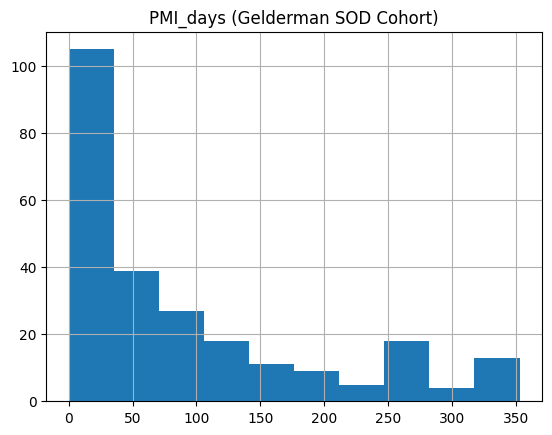

In [73]:
g_data_plus.hist(column='PMI_days')
plt.title('PMI_days (Gelderman SOD Cohort)')
plt.show()

In [74]:
custom_bins = [0,1,2,3,4,5,6,7,8,9,10,  #1
12,14,16,18,20,  #2
23,26,29,32,  #3
36,40,  #4
45,50,  #5
56,61,
68,
76,
85,
95, #10              
106,
118,
131,
145,
160, #15
176,
193,               
211,
230,
250, #20
271,
293,              
316,               
340,
365]

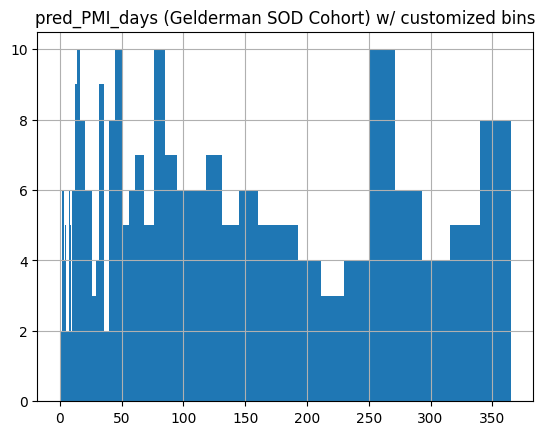

In [75]:
# PMI_days histogram with customized bin widths. 
g_data_plus.hist(column='PMI_days', bins=custom_bins)
plt.title('pred_PMI_days (Gelderman SOD Cohort) w/ customized bins')
plt.show()

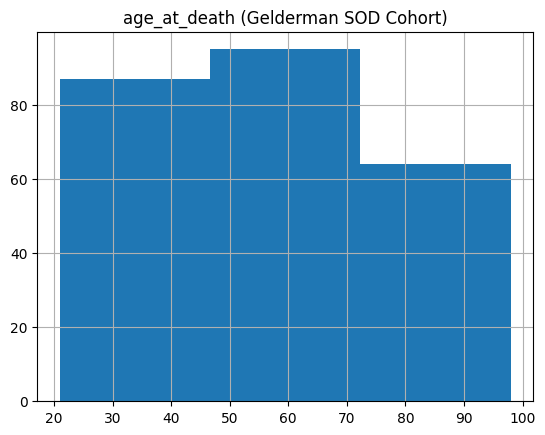

In [76]:
g_data_plus.hist(column='age_at_death', bins=3)
plt.title('age_at_death (Gelderman SOD Cohort)')
plt.show()

In [77]:
g_data_plus['BMI'] = g_data_plus.apply(lambda x: bmi_imperial(x['cadaver_weight_lbs'], x['est_stature_in'])
                                               , axis=1)
g_data_plus['BMI_status'] = g_data_plus.apply(lambda x: bmi_status(x['BMI']), axis=1)
display(g_data_plus.head())

,new_id,donor_date,age_at_death,PMI_days,cadaver_weight_lbs,est_stature_in,BMI,BMI_status
0,004,00400124,67.0,15.0,171.0,64.0,29.3,overweight
1,006,00600212,62.0,34.0,159.0,NaN,NaN,NaN
2,00b,00b00525,62.0,79.0,553.0,73.0,73.0,obese
3,00b,00b00818,62.0,164.0,553.0,73.0,73.0,obese
4,00d,00d10116,98.0,50.0,213.0,73.0,28.1,overweight


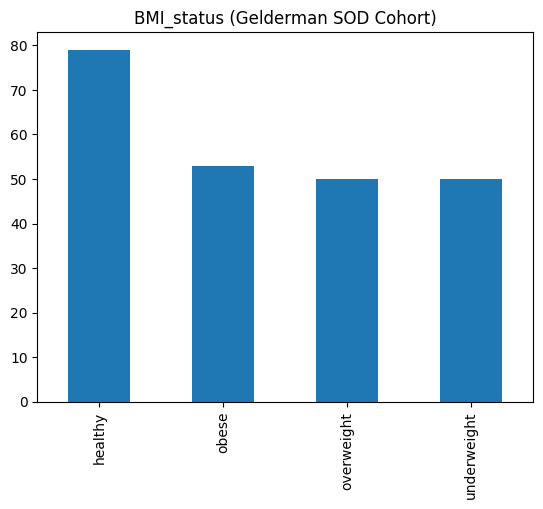

In [78]:
g_data_plus['BMI_status'].value_counts().plot(kind='bar')
plt.title('BMI_status (Gelderman SOD Cohort)')
plt.show()

In [79]:
g_data_plus.new_id.nunique()

143

In [80]:
g_data_plus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249 entries, 0 to 7416809
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   new_id              249 non-null    object 
 1   donor_date          249 non-null    object 
 2   age_at_death        246 non-null    float64
 3   PMI_days            249 non-null    float64
 4   cadaver_weight_lbs  242 non-null    float64
 5   est_stature_in      238 non-null    float64
 6   BMI                 232 non-null    float64
 7   BMI_status          232 non-null    object 
dtypes: float64(5), object(3)
memory usage: 17.5+ KB


## Prepare file for IPCUTRD labeling

In [82]:
new_head = new_samples[['img_head']]
new_head['BP'] = 'head'
new_head.columns = ['img', 'BP']
display(new_head.head(2))

new_torso = new_samples[['img_torso']]
new_torso['BP'] = 'torso'
new_torso.columns = ['img', 'BP']
display(new_torso.head(2))

new_limbs = new_samples[['img_limbs']]
new_limbs['BP'] = 'limbs'
new_limbs.columns = ['img', 'BP']
display(new_limbs.head(2))

all_new = pd.concat([new_head, new_torso, new_limbs], axis=0)
print(len(all_new))

all_new_no_dups = all_new.drop_duplicates('img').copy()
print(len(all_new_no_dups))
display(all_new_no_dups.head())

<ipython-input-82-cc606181aec1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_head['BP'] = 'head'


,img,BP
7483814,dea00127.24.JPG,head
8099352,f0e00519.07.JPG,head


<ipython-input-82-cc606181aec1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_torso['BP'] = 'torso'


,img,BP
7483814,dea00127.06.JPG,torso
8099352,f0e00519.04.JPG,torso


<ipython-input-82-cc606181aec1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_limbs['BP'] = 'limbs'


,img,BP
7483814,dea00127.08.JPG,limbs
8099352,f0e00519.06.JPG,limbs


225
209


,img,BP
7483814,dea00127.24.JPG,head
8099352,f0e00519.07.JPG,head
3894469,7ec00211.07.JPG,head
7277899,dc901011.21.JPG,head
7281739,dc901012.13.JPG,head


In [86]:
# create img_path column
all_new_no_dups['img_path'] = '/da1_data/icputrd/arf/mean.js/public/anau_img3/' \
                                + all_new_no_dups['img'].str[:3] + '/' + all_new_no_dups['img'].astype(str)
display(all_new_no_dups.head())
len(all_new_no_dups)

,img,BP,img_path
7483814,dea00127.24.JPG,head,/da1_data/icputrd/arf/mean.js/public/anau_img3/dea/dea00127.24.JPG
8099352,f0e00519.07.JPG,head,/da1_data/icputrd/arf/mean.js/public/anau_img3/f0e/f0e00519.07.JPG
3894469,7ec00211.07.JPG,head,/da1_data/icputrd/arf/mean.js/public/anau_img3/7ec/7ec00211.07.JPG
7277899,dc901011.21.JPG,head,/da1_data/icputrd/arf/mean.js/public/anau_img3/dc9/dc901011.21.JPG
7281739,dc901012.13.JPG,head,/da1_data/icputrd/arf/mean.js/public/anau_img3/dc9/dc901012.13.JPG


209

In [87]:
# save to CSV file which will be used to populate ICPUTRd for labeling
all_new_no_dups[['img_path', 'BP']].to_csv('/home/anau/SOD_labeling/for_PMI_estimation/additional_labeling_samples.csv',
                                          header=False, index=False)

In [88]:
all_new_no_dups[all_new_no_dups.BP == 'head'].shape

(68, 3)